In [1]:
from sklearn.model_selection import KFold
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, Metric
from numpy import mean, std
import yaml

In [2]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/numpy"
MODEL_PATH = MAIN_PATH + "/models"
LOG_PATH = MAIN_PATH + "/logs"

BEST_VAL_SCORE = 0
BEST_MODEL = None
HISTORY = []  # Initialize history_list

In [3]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

global config
config = load_config('config.yml')

In [4]:
def plot_history_metrics(history_dict: dict):
    total_plots = len(history_dict)
    cols = total_plots // 2
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history_dict.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [5]:
def load_df():
    df = pd.read_csv(MAIN_PATH + "/data/result_df.csv")
    return df

In [6]:
def Clean_missing_values(numpy_data):
    numpy_data['x_train'], numpy_data['y_train'] = Remove_missing_values(numpy_data['x_train'], numpy_data['y_train'])
    numpy_data['x_val'], numpy_data['y_val'] = Remove_missing_values(numpy_data['x_val'], numpy_data['y_val'])
    numpy_data['x_test_1'], numpy_data['y_test_1'] = Remove_missing_values(numpy_data['x_test_1'], numpy_data['y_test_1'])
    numpy_data['x_test_2'], numpy_data['y_test_2'] = Remove_missing_values(numpy_data['x_test_2'], numpy_data['y_test_2'])
    
    return numpy_data

def Remove_missing_values(x_data, y_data):
    # Check if y_data contains missing values (NaNs) and remove corresponding x_data rows
    valid_indices = ~np.isnan(y_data)  # Find valid (non-NaN) indices in y_data
    x_clean = x_data[valid_indices]
    y_clean = y_data[valid_indices]
    return x_clean, y_clean

In [7]:
def gather_numpy_files(data_path):
    numpy_data = {}
    
    for file_name in os.listdir(data_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(data_path, file_name)
            numpy_data[file_name[:-4]] = np.load(file_path)  # Store in dict
    
    # Clean data by removing rows where y_* contains missing values
    numpy_data = Clean_missing_values(numpy_data)

    return numpy_data

In [8]:
def calculate_class_weights(df, label_column):
    vals_dict = {}
    for i in df[label_column]:
        if i in vals_dict.keys():
            vals_dict[i] += 1
        else:
            vals_dict[i] = 1
    total = sum(vals_dict.values())
    weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}

    print(f"Weight dict for model: {weight_dict}")
    return weight_dict

In [9]:
def create_model(given_kernel_size):
    input_layer = keras.Input(shape=(config['input_shape'], config['input_features']))
    
    x = layers.Conv1D(filters=32, kernel_size=given_kernel_size, activation=config['activation'], padding="same", kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=64, kernel_size=given_kernel_size, activation=config['activation'], padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(filters=128, kernel_size=given_kernel_size, activation=config['activation'], padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation=config['activation'], kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256, activation=config['activation'], kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    
    output_layer = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    
    return model


In [10]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [11]:
def Compile_model(kernel_size):
    model = create_model(kernel_size)
    optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=config['learning_rate'])
    loss = keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            F1Score(name='f1_score')
        ],
    )
    return model

In [12]:
def SplitDatasetForFolds(train_index, validation_index, fold_nr, numpy_data):
    print(f"Training fold {fold_nr}...")

    # Split the data into train sets for this fold.
    x_train_fold = numpy_data['x_train'][train_index]
    y_train_fold = numpy_data['y_train'][train_index]

    print(f"x_val shape: {numpy_data['x_val'].shape}")
    print(f"y_val shape: {numpy_data['y_val'].shape}")
    
    # Ensure to use only the training set indices
    x_validation_fold = numpy_data['x_val'][:len(validation_index)]  # Taking the first `len(validation_index)` samples
    y_validation_fold = numpy_data['y_val'][:len(validation_index)]

    # Create tf.data.Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    validation_dataset = tf.data.Dataset.from_tensor_slices((x_validation_fold, y_validation_fold))
    test_dataset_subject1 = tf.data.Dataset.from_tensor_slices((numpy_data['x_test_1'], numpy_data['y_test_1']))	
    test_dataset_subject2 = tf.data.Dataset.from_tensor_slices((numpy_data['x_test_2'], numpy_data['y_test_2']))
    
    # Shuffling and batching the datasets
    train_dataset = train_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])
    validation_dataset = validation_dataset.shuffle(config['shuffle_buffer_size']).batch(config['batch_size'])
    test_dataset_subject1 = test_dataset_subject1.batch(config['batch_size'])
    test_dataset_subject2 = test_dataset_subject2.batch(config['batch_size'])

    return train_dataset, validation_dataset, test_dataset_subject1, test_dataset_subject2


In [13]:
def convert_to_native(data):
    """Recursively convert numpy types to native python types."""
    if isinstance(data, dict):
        return {key: convert_to_native(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_to_native(item) for item in data]
    elif isinstance(data, np.ndarray):
        return data.tolist()  # Convert numpy array to list
    elif isinstance(data, (np.float32, np.float64)):
        return data.item()  # Convert single value numpy float to Python float
    else:
        return data  

In [14]:
def save_history_to_json(history, fold_number, best_model):
    """Save the training history and best model path to a JSON file."""
    try:
        history_data = {
            "history": convert_to_native(history.history),
            "best_model": best_model
        }
        
        history_file_path = os.path.join(LOG_PATH, f"history_fold_{fold_number}.json")
        with open(history_file_path, 'w') as json_file:
            json.dump(history_data, json_file)  # Write the history and best model to a JSON file
        print(f"History and best model saved to {history_file_path}")
    except Exception as e:
        print(f"Error saving history: {e}")

In [15]:
from dvclive import Live
from dvclive.keras import DVCLiveCallback

def Train_fold(train_index, val_index, fold_number, numpy_data, weight_dict, live, kernel_size):
    global BEST_VAL_SCORE, HISTORY 

    # Split data into training and validation sets for this fold
    train_dataset, validation_dataset, test_sj1, test_sj2 = SplitDatasetForFolds(train_index, val_index, fold_number, numpy_data)

    # Create and compile the model
    model = Compile_model(kernel_size)
    model.summary()

    # Set up DVC Live callback for this fold
    live_callback = DVCLiveCallback()

    # Set up other callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            os.path.join(MODEL_PATH, f"best_model_fold_{fold_number}.keras"),
            save_best_only=True,
            monitor="val_accuracy"
        ),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001),
        live_callback
    ]

    print("Starting training...")
    # Train the model
    model.fit(
        train_dataset,
        epochs=5,
        validation_data=validation_dataset,
        callbacks=callbacks,
        class_weight=weight_dict
    )

    fold_performance = model.evaluate(train_dataset, batch_size=config['batch_size'], verbose=0)
    print(f"Train accuracy for fold {fold_number}: {fold_performance[1]}")

    return fold_performance[1]    

In [16]:
def Cross_validation_training(numpy_data, weight_dict, kernel_size):
    global fold_number
    fold_number = 1
    scores = list()

    os.makedirs(MODEL_PATH, exist_ok=True)  # Ensure the model path exists
    # Initialize KFold with the number of splits
    kfold = KFold(n_splits=config['folds'], shuffle=True, random_state=42)

    try:
        for train_index, val_index in kfold.split(numpy_data['x_train']):
            print(f"Training fold {fold_number}")

            live = Live()  # Start a new DVCLive run for this fold

            # Train the current fold
            score = Train_fold(train_index, val_index, fold_number, numpy_data, weight_dict, live, kernel_size)
        
            score = score * 100.0
            print('>p=%d #%d: %.3f'% (kernel_size, fold_number+1, score))
            scores.append(score)

            fold_number += 1
        return scores
        
    except Exception as e:
        print(f"An error occurred during cross-validation training: {e}")

In [17]:
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	plt.boxplot(scores, labels=params)
	plt.xlabel('Kernel Size')
	plt.ylabel('Score')
	plt.title('Model Performance by Kernel Size')
	plt.show()


In [18]:
def main():
    try:
        df = load_df()
        numpy_data = gather_numpy_files(DATA_PATH)

        # test each parameter
        all_scores = list()

        # Calculate weights
        weight_dict = calculate_class_weights(df, 'downsampled_label')
        for kernel_size in config['kernel_sizes']:
            print(f"Running model with kernel size: {kernel_size}")
            # Train model
            scores = Cross_validation_training(numpy_data, weight_dict, kernel_size)
            all_scores.append(scores)
        # summarize results

        print("Cross-validation training completed.\n")

        return all_scores
    except Exception as e:
        print(f"An error occurred in main: {e}")


Weight dict for model: {0: 0.11450662739322537, 1: 0.8854933726067746}
Running model with kernel size: 3
Training fold 1
Training fold 1...
x_val shape: (4988, 32, 1)
y_val shape: (4988,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 32, 32)            128       
                                                                 
 batch_normalization (BatchN  (None, 32, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 conv

c:\Users\goert\.conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


183/183 [==============================] - 13s 36ms/step - loss: 0.9029 - binary_accuracy: 0.7616 - auc: 0.9103 - precision: 0.6928 - recall: 0.9475 - f1_score: 0.8004 - val_loss: 2.7208 - val_binary_accuracy: 0.5000 - val_auc: 0.5978 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 2/5
183/183 [==============================] - 6s 35ms/step - loss: 0.5995 - binary_accuracy: 0.7637 - auc: 0.9156 - precision: 0.6901 - recall: 0.9648 - f1_score: 0.8046 - val_loss: 2.8693 - val_binary_accuracy: 0.5000 - val_auc: 0.6815 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1_score: 0.6667 - lr: 0.0010
Epoch 3/5
183/183 [==============================] - 6s 35ms/step - loss: 0.4150 - binary_accuracy: 0.7642 - auc: 0.9172 - precision: 0.6890 - recall: 0.9705 - f1_score: 0.8059 - val_loss: 2.1583 - val_binary_accuracy: 0.5305 - val_auc: 0.7909 - val_precision: 0.5157 - val_recall: 0.9992 - val_f1_score: 0.6803 - lr: 0.0010
Epoch 4/5
183/183 [===============

    dvc remote add -d <remote name> <remote url>
	notebooks/config.yml


Train accuracy for fold 1: 0.5549863576889038
>p=3 #2: 55.499
Training fold 2
Training fold 2...
x_val shape: (4988, 32, 1)
y_val shape: (4988,)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 32)            128       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32)           128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 16, 64)   

    dvc remote add -d <remote name> <remote url>
	notebooks/config.yml


Train accuracy for fold 2: 0.6302937269210815
>p=3 #3: 63.029
Cross-validation training completed.

[[55.49863576889038, 63.029372692108154]] [3]
Param=3: 59.264% (+/-3.765)


C:\Users\goert\AppData\Local\Temp\ipykernel_23312\821211489.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(scores, labels=params)


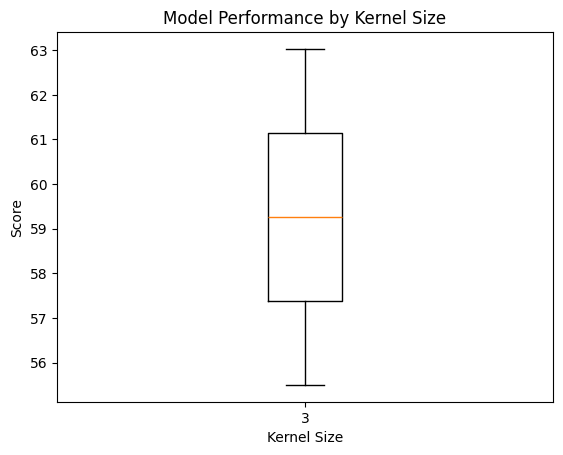

In [19]:
all_scores = main()

summarize_results(all_scores, config['kernel_sizes'])